# Decision Trees on Donors Choose Dataset

# Import libraries

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import pickle

# nltk.download('vader_lexicon')
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()



# Load all the libraries used in this notebook
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier

from scipy.sparse import hstack
from tqdm import tqdm
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

<font color='red'><b> TF-IDFW2V</b></font>

<b>Tfidf w2v (w1,w2..) = (tfidf(w1) * w2v(w1) + tfidf(w2) * w2v(w2) + …)  /    (tfidf(w1) + tfidf(w2) + …)</b>

### Loading Glove Vectors

In [ ]:
#please use below code to load glove vectors 
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# <font color='red'> <b>Part - 1</b></font>

<ol>
    <li><strong>We will apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features +  preprocessed_essay (TFIDF) + Sentiment scores(preprocessed_essay)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features +  preprocessed_essay (TFIDF W2V) + Sentiment scores(preprocessed_essay)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>We will find the best hyper parameter which will give the maximum AUC value</li>
    <li>To find the best hyperparamters we are going to use k-fold cross validation(using Grid-Search cv or Random-Search CV)</li>
        </ul>
    </li>
    </li>
   

# <font color='red'><b> Part - 2 </b></font>

For this part we are going to consider **set-1** features.

*  We will select all the features which are having non-zero feature importance.We will obtain the feature importance using  'feature_importances_` 
, discard the all other remaining features and then apply any of the model of our choice i.e. (Dession tree, Logistic Regression, Linear SVM).

*  We will do hyperparameter tuning corresponding to above model <br>
  **Note**: when we want to find the feature importance we have to make sure we are not use max_depth parameter, it should be kept None.
  </li>
    <br>
At the end we will summarize the results in a table format
    </li>
</ol>

# 1. Decision Tree

## 1.1 Loading Data

___
#### NOTE: Here we need not process the numerical features as it is not necessary in Decision Trees

In [ ]:
# Load the data
data = pd.read_csv('preprocessed_data.csv')

In [ ]:
# Seperate the X,y
y = data['project_is_approved']
data.drop(['project_is_approved'], inplace=True, axis=1)

## 1.2 Split the data into Train and Test  Dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.30, stratify = y)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((76473, 8), (32775, 8), (76473,), (32775,))

## 1.3 Find the sentiment score for the essay feature

In [ ]:
# Let's create 4 empty lists corresponding to 'neg', 'neu', 'pos', 'compound'
neg_train, neu_train, pos_train, compound_train = [], [], [], []

# Initialize the sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# This is for the train dataset
for sentence in tqdm(X_train['essay'].values):               # For each essay in the train dataset
        
    # Find the sentiment scores
    sentiment_score = sid.polarity_scores(sentence)
    
    # Append the 'neg' , 'neu', 'pos', 'compound' values calculated for each essay
    neg_train.append(sentiment_score['neg'])
    neu_train.append(sentiment_score['neu'])
    pos_train.append(sentiment_score['pos'])
    compound_train.append(sentiment_score['compound'])


100%|███████████████████████████████████████████████████████████████████████████| 76473/76473 [07:26<00:00, 171.33it/s]


In [ ]:
# Changing the Shape of the vectors
neg_train, neu_train, pos_train, compound_train = np.reshape(np.array(neg_train),(-1,1)), np.reshape(np.array(neu_train),(-1,1)), np.reshape(np.array(pos_train),(-1,1)),  np.reshape(np.array(compound_train), (-1,1))

In [ ]:
# The same can be done for the test dataset
neg_test, neu_test, pos_test, compound_test = [], [], [], []

# Initialize the sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# This is for the test dataset
for sentence in tqdm(X_test['essay'].values):               # For each essay in the test dataset
        
    # Find the sentiment scores
    sentiment_score = sid.polarity_scores(sentence)
    
    # Append the 'neg' , 'neu', 'pos', 'compound' values calculated for each essay
    neg_test.append(sentiment_score['neg'])
    neu_test.append(sentiment_score['neu'])
    pos_test.append(sentiment_score['pos'])
    compound_test.append(sentiment_score['compound'])


100%|███████████████████████████████████████████████████████████████████████████| 32775/32775 [02:55<00:00, 186.48it/s]


In [ ]:
# Changing the shape of the vectors
neg_test, neu_test, pos_test, compound_test = np.reshape(np.array(neg_test),(-1,1)), np.reshape(np.array(neu_test),(-1,1)), np.reshape(np.array(pos_test),(-1,1)),  np.reshape(np.array(compound_test), (-1,1))

## 1.4 Encoding essay

### 1.4.1 Set 1 features: TFIDF vectorization

In [ ]:
# Initialize the vectorizer
tfidf = TfidfVectorizer()

# Fit and then transform on behalf of the train data
X_train_essay_tfidf = tfidf.fit_transform(X_train['essay'].values)

# Transform the test essay values
X_test_essay_tfidf = tfidf.transform(X_test['essay'].values)

# Shape after vectorization
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print('='*100)

(76473, 48734) (76473,)
(32775, 48734) (32775,)


### 1.4.2 Set 2 feature: TFIDF - W2V Vectorization

#### 1.4.2.1 For the Train Data

In [ ]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

In [ ]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 76473/76473 [05:04<00:00, 251.30it/s]

76473
300


In [ ]:
# Reshaping the tfidf_w2v vector to match the shape of the train data
X_train_tfidf_w2v_vectors = np.reshape(tfidf_w2v_vectors, (len(tfidf_w2v_vectors),300))
X_train_tfidf_w2v_vectors.shape

(76473, 300)

#### 1.4.2.2 For Test data

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
X_test_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list

for sentence in tqdm(X_test['essay'].values): # for each review/sentence
    
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    
    for word in sentence.split(): # for each word in a review/sentence
        
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    
    X_test_tfidf_w2v_vectors.append(vector)

# Reshaping the tfidf_w2v vector to match the shape of the test data
X_test_tfidf_w2v_vectors = np.reshape(X_test_tfidf_w2v_vectors, (len(X_test_tfidf_w2v_vectors),300))

print(X_test_tfidf_w2v_vectors.shape)

100%|███████████████████████████████████████████████████████████████████████████| 32775/32775 [02:14<00:00, 243.41it/s]


(32775, 300)


## 1.5 Encoding Categorical Features 

### 1.5.1 School State

In [ ]:
ss = CountVectorizer(binary=True)

X_train_ss = ss.fit_transform(X_train['school_state'].values)
X_test_ss = ss.transform(X_test['school_state'].values)

print(X_train_ss.shape, y_train.shape)
print(X_test_ss.shape, y_test.shape)
print('='*100)

(76473, 51) (76473,)
(32775, 51) (32775,)


### 1.5.2 teacher_prefix OHE

In [ ]:
tp = CountVectorizer(binary=True)

X_train_tp = tp.fit_transform(X_train['teacher_prefix'].values)
X_test_tp = tp.transform(X_test['teacher_prefix'].values)

print(X_train_tp.shape, y_train.shape)
print(X_test_tp.shape, y_test.shape)
print('='*100)

(76473, 5) (76473,)
(32775, 5) (32775,)


### 1.5.3 project_grade_category OHE

In [ ]:
pgc = CountVectorizer(binary=True)

X_train_pgc = pgc.fit_transform(X_train['project_grade_category'].values)
X_test_pgc = pgc.transform(X_test['project_grade_category'].values)

print(X_train_pgc.shape, y_train.shape)
print(X_test_pgc.shape, y_test.shape)
print('='*100)

(76473, 4) (76473,)
(32775, 4) (32775,)


### 1.5.4 clean_categories

In [ ]:
cc = CountVectorizer(binary=True)

X_train_cc = cc.fit_transform(X_train['clean_categories'].values)
X_test_cc = cc.transform(X_test['clean_categories'].values)

print(X_train_cc.shape, y_train.shape)
print(X_test_cc.shape, y_test.shape)
print('='*100)

(76473, 9) (76473,)
(32775, 9) (32775,)


### 1.5.5  clean_subcategories

In [ ]:
csc = CountVectorizer(binary=True)

X_train_csc = csc.fit_transform(X_train['clean_subcategories'].values)
X_test_csc = csc.transform(X_test['clean_subcategories'].values)

print(X_train_csc.shape, y_train.shape)
print(X_test_csc.shape, y_test.shape)
print('='*100)

(76473, 30) (76473,)
(32775, 30) (32775,)


### 1.5.6 Price

In [ ]:
X_train_price = X_train['price'].values.reshape(-1,1)
X_test_price = X_test['price'].values.reshape(-1,1)

print(X_train_price.shape, y_train.shape)
print(X_test_price.shape, y_test.shape)
print('='*100)

(76473, 1) (76473,)
(32775, 1) (32775,)


### 1.5.7 teacher_number_of_previously_posted_projects

In [ ]:
X_train_tnoppp = X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
X_test_tnoppp = X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)

print(X_train_tnoppp.shape, y_train.shape)
print(X_test_tnoppp.shape, y_test.shape)
print('='*100)

(76473, 1) (76473,)
(32775, 1) (32775,)


## 1.6  Use GridSearchCV for Hyper-parameter tuning

## 1.6.1 SET-1 features

### 1.6.1.1 GridSearchCV Using TFIDF essay + other features

In [ ]:
dt = DecisionTreeClassifier()
parameters = {'min_samples_split':[5, 10, 100, 500] , 'max_depth':[1, 5, 10, 50]}


# Add the features obtained from sentiment scores
X_tr = hstack((X_train_ss,X_train_tp,X_train_pgc,X_train_tnoppp,X_train_cc,X_train_csc,X_train_essay_tfidf, X_train_price, neg_train, neu_train, pos_train, compound_train)).tocsr()
X_te = hstack((X_test_ss,X_test_tp,X_test_pgc,X_test_tnoppp,X_test_cc,X_test_csc,X_test_essay_tfidf,X_test_price, neg_test, neu_test, pos_test, compound_test)).tocsr()

# We are going to use GridSearchCV or RandomSearchCV to find which value(s) of hyperparameter gives us the best AUC score
clf = GridSearchCV(dt, parameters, cv=5, scoring='roc_auc', return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)

In [ ]:
# Reference : https://stackoverflow.com/questions/39041865/three-variables-as-heatmap
results_pivoted_train = results.pivot('param_max_depth','param_min_samples_split', 'mean_train_score')
results_pivoted_train

param_min_samples_split,5,10,100,500
param_max_depth,,,,
1,0.553748,0.553748,0.553748,0.553748
5,0.641207,0.641188,0.641127,0.640951
10,0.702897,0.701872,0.697126,0.692801
50,0.916775,0.910063,0.884812,0.845485


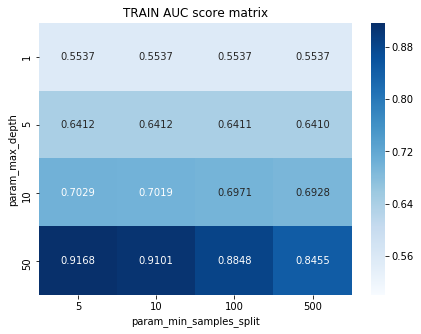

In [ ]:
# Plotting the performance of the model corresponding to different parameter values for the train dataset

plt.figure(figsize=(7,5))
ax= plt.subplot();

sns.heatmap(results_pivoted_train,vmin=0.5, annot=True,ax=ax, cmap="Blues", fmt='.4f');

# labels, title and ticks
ax.set_ylim((4.0), 0)
ax.set_title('TRAIN AUC score matrix');

In [ ]:
results_pivoted_test = results.pivot('param_max_depth','param_min_samples_split', 'mean_test_score')
results_pivoted_test

param_min_samples_split,5,10,100,500
param_max_depth,,,,
1,0.551105,0.551105,0.551105,0.551105
5,0.622880,0.622971,0.622955,0.623468
10,0.639801,0.639275,0.643616,0.647892
50,0.545303,0.549380,0.580493,0.619464


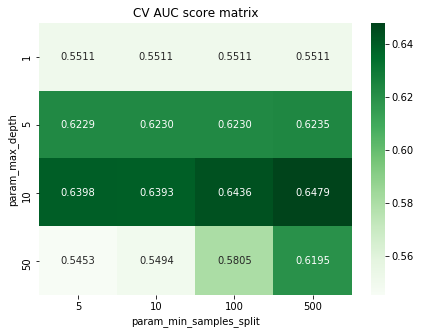

In [ ]:
# Plotting the performance of the model corresponding to different parameter values for the test dataset

plt.figure(figsize=(7,5))
ax= plt.subplot();

sns.heatmap(results_pivoted_test, annot=True,ax=ax, cmap="Greens", fmt='.4f');

# labels, title and ticks
ax.set_ylim((4.0), 0)
ax.set_title('CV AUC score matrix');

### 1.6.1.2 Train the model with the best hyperparameters obtained

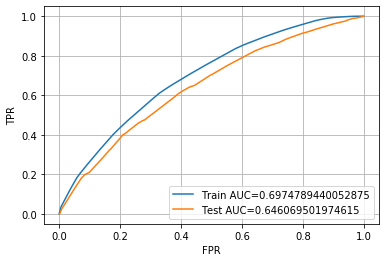

In [ ]:
# First fit the model with the best hyperparameters i.e. max_depth = 10, and min_samples_split=100

# Stack all the train and test features
X_tr = hstack((X_train_ss,X_train_tp,X_train_pgc,X_train_tnoppp,X_train_cc,X_train_csc,X_train_essay_tfidf, X_train_price, neg_train, neu_train, pos_train, compound_train)).tocsr()
X_te = hstack((X_test_ss,X_test_tp,X_test_pgc,X_test_tnoppp,X_test_cc,X_test_csc,X_test_essay_tfidf,X_test_price, neg_test, neu_test, pos_test, compound_test)).tocsr()

# Fit the Decision Tree model
clf = DecisionTreeClassifier(max_depth=10, min_samples_split=100)
clf.fit(X_tr, y_train)

# store the predicted class probalbility values for the positive class, for the train dataset
y_train_pred = clf.predict_proba(X_tr)
y_train_pred_1 = y_train_pred[:, 1]

# Smilarly storing the class 1 probability values for the test data
y_test_pred = clf.predict_proba(X_te)
y_test_pred_1 = y_test_pred[:, 1]

# Plot the ROC curve 
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_1)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_1)

# Plot the ROC-AUC curve
plt.plot(train_fpr, train_tpr, label='Train AUC='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test AUC='+str(auc(test_fpr, test_tpr)))
plt.grid()
plt.legend()
plt.title("")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show();

In [ ]:
# the best threshold will be the one for which the tpr*(1-fpr) value is the maximum
def find_best_thresold(thresholds, fpr, tpr):
    t = thresholds[np.argmax(tpr*(1-fpr))]
    print(f"The best thershold for which tpr-(1-fpr) is maximum is {t}")
    return t

# This function returns the class label for a given threshold and probalbilty value 
def predict_with_best_proba(proba, threshold):
    
    predictions = []
    
    for i in proba:
        if i> threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
# Find the best threshold

best_threshold = find_best_thresold(tr_thresholds, train_fpr, train_tpr)

# Print the TRAIN confusion matrix
print("Train Confusion matrix:\n",confusion_matrix(y_train, predict_with_best_proba(y_train_pred_1, best_threshold)))

# Print the Test confusion matrix
print("Test Confusion matrix:\n",confusion_matrix(y_test, predict_with_best_proba(y_test_pred_1, best_threshold)))

The best thershold for which tpr-(1-fpr) is maximum is 0.84850640113798
Train Confusion matrix:
 [[ 7589  3990]
 [24183 40711]]
Test Confusion matrix:
 [[ 2943  2020]
 [10466 17346]]


### 1.6.1.3 Plot the train and test confusion matrices

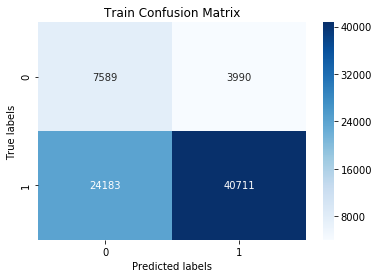

In [ ]:
# Reference : https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor

# Store the confusion matrix and use it to plot the heatmap
cm=confusion_matrix(y_traina, predict_with_best_proba(y_train_pred_1, best_threshold))

ax= plt.subplot();
sns.heatmap(cm, annot=True,cmap='Blues',ax=ax,fmt='d');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Train Confusion Matrix');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);

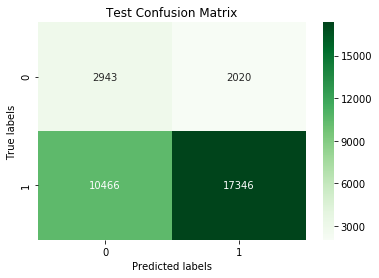

In [ ]:
# Reference : https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor

# Store the confusion matrix and use it to plot the heatmap
cm=confusion_matrix(y_test, predict_with_best_proba(y_test_pred_1, best_threshold))

ax= plt.subplot();
sns.heatmap(cm, annot=True,cmap='Greens',ax=ax,fmt='d');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Test Confusion Matrix');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);

### 1.6.1.4 Obtaning the False Positive Data points

In [ ]:
# Get all the false positive data points
# False positive = Predicting to be in Class 1 but actually belonging to class 0
#  i.e. y_pred = 1 and y_actual = 0

y_predicted = predict_with_best_proba(y_test_pred_1, best_threshold)

indices = []
fp_data_points = []
# store the indices of the false positive data points and then access them from the test data
for i in range(len(y_predicted)):
    # Check if its a FP data point
    if y_test.iloc[i]==0 and y_predicted[i]==1:
        indices.append(i)
        fp_data_points.append(X_test.iloc[i,:])
len(fp_data_points)

2020

### 1.6.1.5 Plot the WordCloud for False Positive essay features

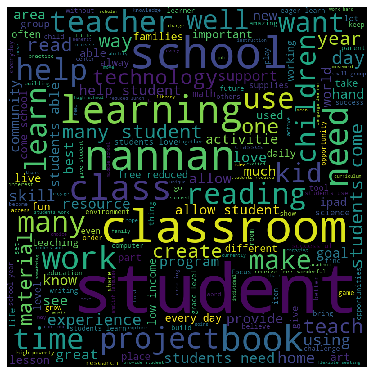

In [ ]:
# Reference : https://www.geeksforgeeks.org/generating-word-cloud-python/
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd


df = pd.DataFrame(fp_data_points)

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.essay:
	
	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='black',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


### 1.6.1.6 Plot the box plot with the `price` of these `false positive data points`

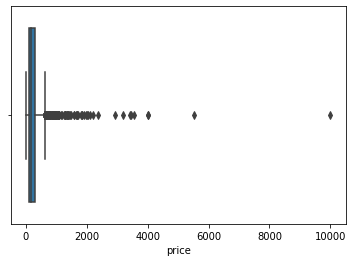

In [ ]:
sns.boxplot(df.price);

### 1.6.1.7 Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data` points

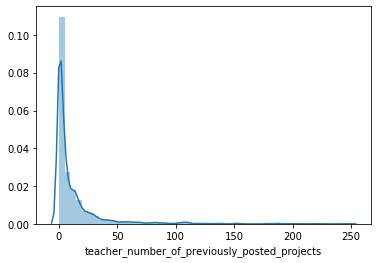

In [ ]:
sns.distplot(df.teacher_number_of_previously_posted_projects);

## 1.6.2 SET-2 features

### 1.6.2.1 GridSearchCV Using TFIDF_W2V essay + other features

In [ ]:
dt = DecisionTreeClassifier()
parameters = {'min_samples_split':[5, 10, 100, 500] , 'max_depth':[1, 5, 10, 50]}


# Add the features obtained from sentiment scores
X_tr = hstack((X_train_ss,X_train_tp,X_train_pgc,X_train_tnoppp,X_train_cc,X_train_csc,X_train_tfidf_w2v_vectors, X_train_price, neg_train, neu_train, pos_train, compound_train)).tocsr()

# We are going to use GridSearchCV or RandomSearchCV to find which value(s) of hyperparameter gives us the best AUC score
clf = GridSearchCV(dt, parameters, cv=5, scoring='roc_auc', return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)

In [ ]:
# Reference : https://stackoverflow.com/questions/39041865/three-variables-as-heatmap
results_pivoted_train = results.pivot('param_max_depth','param_min_samples_split', 'mean_train_score')
results_pivoted_train

param_min_samples_split,5,10,100,500
param_max_depth,,,,
1,0.563199,0.563199,0.563199,0.563199
5,0.659546,0.659542,0.659495,0.659361
10,0.759198,0.757787,0.744105,0.723815
50,0.999428,0.995674,0.928783,0.796493


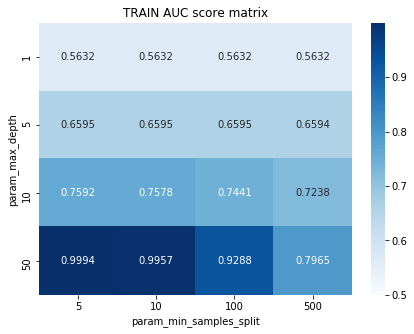

In [ ]:
plt.figure(figsize=(7,5))
ax= plt.subplot();


sns.heatmap(results_pivoted_train,vmin=0.5, annot=True,ax=ax, cmap="Blues", fmt='.4f');

# labels, title and ticks
ax.set_ylim((4.0), 0)
ax.set_title('TRAIN AUC score matrix');

In [ ]:
results_pivoted_test = results.pivot('param_max_depth','param_min_samples_split', 'mean_test_score')
results_pivoted_test

param_min_samples_split,5,10,100,500
param_max_depth,,,,
1,0.561942,0.561942,0.561942,0.561942
5,0.635209,0.635265,0.635229,0.635300
10,0.616958,0.618775,0.625649,0.630871
50,0.535630,0.539549,0.574806,0.614457


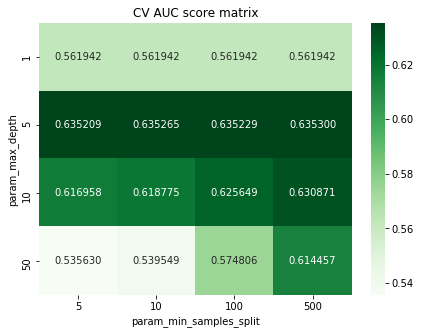

In [ ]:
plt.figure(figsize=(7,5))
ax= plt.subplot();


sns.heatmap(results_pivoted_test, annot=True,ax=ax, cmap="Greens", fmt='.6f');

# labels, title and ticks
ax.set_ylim((4.0), 0)
ax.set_title('CV AUC score matrix');

### 1.6.2.2 Train the model with the best hyperparameters

In [ ]:
# The best hyper parameters are : max_depth = 10, min_samples_spilt = 500
# Now we need to use this hyperparameters to train the model, plot the ROC curve, which requires us to find the best threshold
# print the confusion matrix

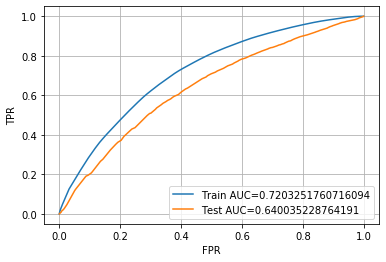

In [ ]:
# First fit the model with the best hyperparameters

X_tr = hstack((X_train_ss,X_train_tp,X_train_pgc,X_train_tnoppp,X_train_cc,X_train_csc,X_train_tfidf_w2v_vectors, X_train_price, neg_train, neu_train, pos_train, compound_train)).tocsr()
X_te = hstack((X_test_ss,X_test_tp,X_test_pgc,X_test_tnoppp,X_test_cc,X_test_csc,X_test_tfidf_w2v_vectors,X_test_price, neg_test, neu_test, pos_test, compound_test)).tocsr()

clf = DecisionTreeClassifier(max_depth=10, min_samples_split=500)
clf.fit(X_tr, y_train)

# Store the predicted train probabilities for class 1
y_train_pred = clf.predict_proba(X_tr)
y_train_pred_1 = y_train_pred[:, 1]

# Store the predicted test probabilities for class 1
y_test_pred = clf.predict_proba(X_te)
y_test_pred_1 = y_test_pred[:, 1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_1)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_1)

# Plot the ROC curve
plt.plot(train_fpr, train_tpr, label='Train AUC='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test AUC='+str(auc(test_fpr, test_tpr)))
plt.grid()
plt.legend()
plt.title("")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show();

In [ ]:
# Find the best threshold

best_threshold = find_best_thresold(tr_thresholds, train_fpr, train_tpr)

# Print the TRAIN confusion matrix
print("Train Confusion matrix:\n",confusion_matrix(y_train, predict_with_best_proba(y_train_pred_1, best_threshold)))

# Print the Test confusion matrix
print("Test Confusion matrix:\n",confusion_matrix(y_test, predict_with_best_proba(y_test_pred_1, best_threshold)))



The best thershold for which tpr-(1-fpr) is maximum is 0.8604118993135011
Train Confusion matrix:
 [[ 7371  4208]
 [19844 45050]]
Test Confusion matrix:
 [[ 2677  2286]
 [ 9022 18790]]


### 1.6.2.3 Plot the Train and Test set Confusion Matrices 

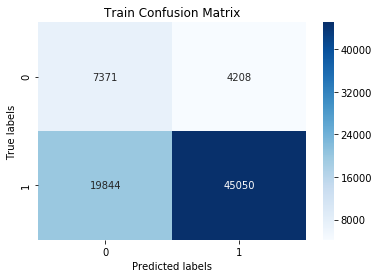

In [ ]:
# Reference : https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor

# Store the confusion matrix and use it to plot the heatmap
cm=confusion_matrix(y_train, predict_with_best_proba(y_train_pred_1, best_threshold))

ax= plt.subplot();
sns.heatmap(cm, annot=True,cmap='Blues',ax=ax,fmt='d');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Train Confusion Matrix');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);

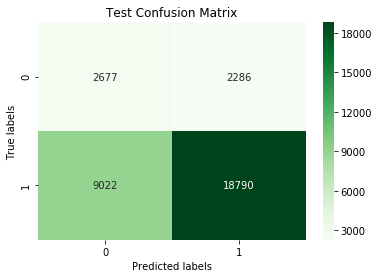

In [ ]:
# Reference : https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor

# Store the confusion matrix and use it to plot the heatmap
cm=confusion_matrix(y_test, predict_with_best_proba(y_test_pred_1, best_threshold))

ax= plt.subplot();
sns.heatmap(cm, annot=True,cmap='Greens',ax=ax,fmt='d');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Test Confusion Matrix');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);

### 1.6.2.4 Obtain the False Positive Data Points

In [ ]:
# Get all the false positive data points
# False positive = Predicting to be in Class 1 but actually belonging to class 0
#  i.e. y_pred = 1 and y_actual = 0

y_predicted = predict_with_best_proba(y_test_pred_1, best_threshold)

indices = []
fp_data_points = []
# store the indices of the false positive data points and then access them from the test data
for i in range(len(y_predicted)):
    # Check if its a FP data point
    if y_test.iloc[i]==0 and y_predicted[i]==1:
        indices.append(i)
        fp_data_points.append(X_test.iloc[i,:])
len(fp_data_points)

2286

### 1.6.2.5 Plotting the WordCloud for the essay feature of the False Positive Data points

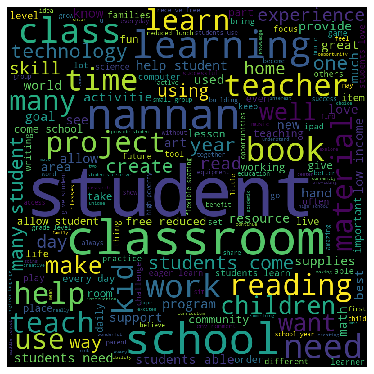

In [ ]:
# Reference : https://www.geeksforgeeks.org/generating-word-cloud-python/
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd


df = pd.DataFrame(fp_data_points)

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.essay:
	
	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='black',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


### 1.6.2.6 Plot the box plot with the `price` of these `false positive data points`

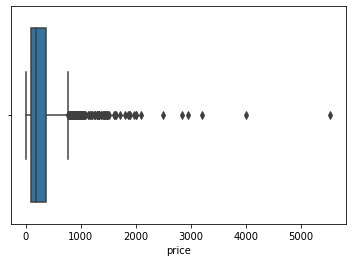

In [ ]:
sns.boxplot(df.price);

### 1.6.2.7 Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive` data points

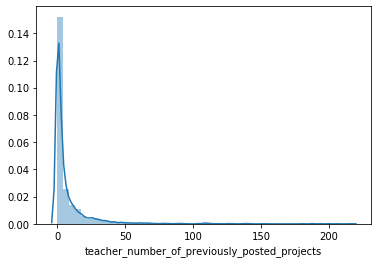

In [ ]:
sns.distplot(df.teacher_number_of_previously_posted_projects);

# Part 2

## 2.1 Taking the Set-1 features and fitting a DT classifier to obtain feature importance

In [ ]:
# Set-1 features
X_tr = hstack((X_train_ss,X_train_tp,X_train_pgc,X_train_tnoppp,X_train_cc,X_train_csc,X_train_essay_tfidf, X_train_price, neg_train, neu_train, pos_train, compound_train)).tocsr()

# Fit the model using the features
clf = DecisionTreeClassifier()
clf.fit(X_tr, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

## 2.2 Get the features having non-zero feature importances 

In [ ]:
# We need to have the index corresponding to the feature having non-zero feature importance
# we are going to run a loop for the range (0,len(clf.feature_importances_)) and then store the indexes corresponding 
# to which the index is not zero
indexes = []
feature_imp = clf.feature_importances_
for i in range(len(feature_imp)):     # For each index of the feature importance list
    if feature_imp[i] != 0:
        indexes.append(i)             # Store the non-zero feature value index
# The number of non-zero feature importance values
print(len(indexes))            

3600


In [ ]:
# Storing the train data for the non-zero feature importance values
X_tr = hstack((X_train_ss,X_train_tp,X_train_pgc,X_train_tnoppp,X_train_cc,X_train_csc,X_train_essay_tfidf, X_train_price, neg_train, neu_train, pos_train, compound_train)).tocsr()
X_tr = X_tr[:,indexes]

In [ ]:
# Storing the test data for the non-zero feature importance values
X_te = hstack((X_test_ss,X_test_tp,X_test_pgc,X_test_tnoppp,X_test_cc,X_test_csc,X_test_essay_tfidf, X_test_price, neg_test, neu_test, pos_test, compound_test)).tocsr()
X_te = X_te[:, indexes]

## 2.3 Fitting a Logistic Regression model on the above selected data

### 2.3.1 Hyperparameter tuning using GridSearchCV

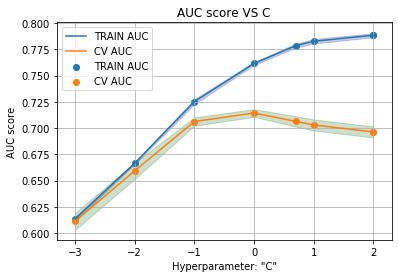

In [ ]:
# Fit a Logistic regression model
logreg = LogisticRegression()
logreg.fit(X_tr, y_train)

parameters = {'C':[0.001, 0.01, 0.1, 1, 5, 10, 100, 100]}

# Using Grid-search to find the optimal hyperparameter
clf = GridSearchCV(logreg, parameters, cv=5, scoring='roc_auc', return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame(clf.cv_results_)

# Train and CV scores
train_auc = results['mean_train_score']
train_auc_std = results['std_train_score']
cv_auc = results['mean_test_score']
cv_auc_std = results['std_test_score']

C = np.log10(results['param_C'].apply(float)).values    # Taking log of the C values

# Plot the Train and the CV score
plt.plot(C, train_auc, label='TRAIN AUC')
plt.gca().fill_between(C, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(C, cv_auc, label='CV AUC')
plt.gca().fill_between(C,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkgreen')

plt.scatter(C, train_auc, label='TRAIN AUC')
plt.scatter(C, cv_auc, label='CV AUC')

plt.grid()
plt.legend()
plt.xlabel('Hyperparameter: "C"')
plt.ylabel('AUC score')
plt.title(f'AUC score VS C')
plt.show();

### 2.3.2 Fit the Logistic regression model with the best hyperparameters

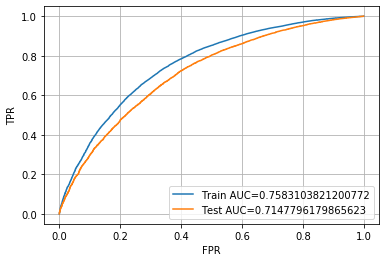

In [ ]:
# From here the best log(C) = 0, C=1;
# Fit Logistic Regression with the best hyperparameters
clf = LogisticRegression(C=1)
clf.fit(X_tr, y_train)

# predicting for the train data
y_train_pred = clf.predict_proba(X_tr)
y_train_pred_1 = y_train_pred[:, 1]

# Predicting the class probabilities for the test data
y_test_pred = clf.predict_proba(X_te)
y_test_pred_1 = y_test_pred[:, 1]

# Prepairing to plot the ROC curve, so we need the TPR and FPR values
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_1)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_1)

# Plotting the ROC curve
plt.plot(train_fpr, train_tpr, label='Train AUC='+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test AUC='+str(auc(test_fpr, test_tpr)))
plt.grid()
plt.legend()
plt.title("")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show();

In [ ]:
# Find the best threshold

best_threshold = find_best_thresold(tr_thresholds, train_fpr, train_tpr)

# Print the TRAIN confusion matrix
print("Train Confusion matrix:\n",confusion_matrix(y_train, predict_with_best_proba(y_train_pred_1, best_threshold)))

# Print the Test confusion matrix
print("Test Confusion matrix:\n",confusion_matrix(y_test, predict_with_best_proba(y_test_pred_1, best_threshold)))


The best thershold for which tpr-(1-fpr) is maximum is 0.8301557199214405
Train Confusion matrix:
 [[ 7736  3843]
 [17869 47025]]
Test Confusion matrix:
 [[ 3032  1931]
 [ 8004 19808]]


### 2.3.3 Plot the Train and Test confusion matrices

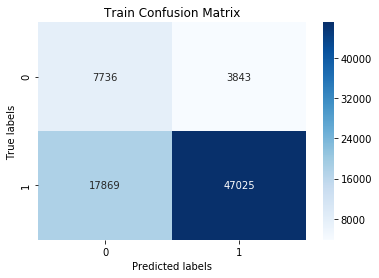

In [ ]:
# Reference : https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor

# Store the confusion matrix and use it to plot the heatmap
cm=confusion_matrix(y_train, predict_with_best_proba(y_train_pred_1, best_threshold))

ax= plt.subplot();
sns.heatmap(cm, annot=True,cmap='Blues',ax=ax,fmt='d');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Train Confusion Matrix');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);

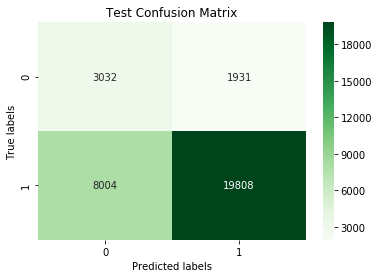

In [ ]:
# Reference : https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor

# Store the confusion matrix and use it to plot the heatmap
cm=confusion_matrix(y_test, predict_with_best_proba(y_test_pred_1, best_threshold))

ax= plt.subplot();
sns.heatmap(cm, annot=True,cmap='Greens',ax=ax,fmt='d');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Test Confusion Matrix');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);